<a href="https://colab.research.google.com/github/andxeg/ipp-clf-eeg/blob/dev/EDF_analysis_and_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import json
import subprocess
import traceback
import torch
import mne
import scipy
import json
import torchvision
import multiprocessing

import scipy.signal

import matplotlib.pyplot as plt
import numpy as np


C:\Users\pegasko\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# > Configuration

In [ ]:
# Path config

DATA_PATH  = 'Cleared-converted'
VISUAL_SUBPATH = 'Visual'
AUDIAL_SUBPATH = 'Audial'

# Data config

TARGET_CHANNELS = 4
TARGET_CHANNEL_SETS = [
	[ 'EEG F7-A1', 'EEG F7-M1' ],
	[ 'EEG F3-A1', 'EEG F3-M1' ],
	[ 'EEG T3-A1', 'EEG T3-M1' ],
	[ 'EEG C3-A1', 'EEG C3-M1' ],
]
SOURCE_FREQ     = 1000 # Article: 1000Hz
# Original size
SECTOR_LENGTH   = 600
MAX_MORLET_FREQ = 30
# Target size
TARGET_SECTOR_LENGTH = 600
TARGET_MORLET_FREQ   = 30
# Filter
LOW_PASS_FREQ   = 3
HIGH_PASS_FREQ  = 30

# Phonemes are enumerated in range 2, 3, 4, 5, 6, 7, 8
MIN_PHONEME_ID = 2
PHONEME_COUNT  = 7

# Directories
MORLET_SAVE_DIR = 'morlet'

# List of EDF files to use
# These files are taken from DATA_PATH/VISUAL_SUBPATH and DATA_PATH/AUDIAL_SUBPATH
INPUT_EDF_LIST = [
	'Antonovazrf_och',
	'BazvlkDzrf_och',
	'DachaPapzrf_och',
	'Drachenkozrf_och',
	'Gordokovzrf_och',
	'Manenkovzrf_och',
	'pavluhinNzrf_och',
	'rylkovSzrf_och',
	'Sazanovazrf_och',
	'vinickiDzrf_och',
]


# > Basic functions for data processing & train

## Read EDF files, extract, split into sectors 

In [ ]:
def extract_sectors(edf): # Returns sectors[begin,end] and missing_labels
	"""
	Extract valid and invalid sectors from edf data file
	"""
	sectors = []
	missing_labels = []
	last_label = None
	last_label_index = None
	
	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]

	for index, (timestamp, value) in enumerate(zip(X, Y)):
		if value > 0:
			value = int(value)
			
			# Phoneme begin
			if value // 10 == 1:
				if last_label is not None:
					if last_label // 10 == 1:
						missing_labels.append(last_label_index)
				
				last_label = value
				last_label_index = index
			
			# Phoneme end
			elif value // 10 == 2:
				if last_label is not None:
					if last_label % 10 != value % 10:
						missing_labels.append(last_label_index)
						missing_labels.append(index)
					else:
						sectors.append((last_label_index, index))
						last_label = None
				else:
					missing_labels.append(index)
	
	return sectors, missing_labels

def extract_strict_sectors(edf, sector_length): # Returns sectors[begin,end] and labels
	"""
	Extract sectors of the given length using begin and start labels.
	Sample usage is extracting sectors of length 600 ms (1000Hz).
	"""
	
	sectors = []
	labels = []
	invalid_labels = []
	last_sector_end_index = None
	
	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]

	for index, (timestamp, value) in enumerate(zip(X, Y)):
		if value > 0:
			
			if last_sector_end_index is not None and index < last_sector_end_index:
				invalid_labels.append(index)
				continue
			
			# Assume that sector [index : index+sector_length] does not 
			#  intersect with other sector [index2 : index2+sector_length]
			value = int(value)
			
			# Phoneme begin
			if value // 10 == 1:
				
				if index + sector_length > len(X):
					invalid_labels.append(index)
					continue
				
				# Append sector from current position to current+sector_length as sector
				sectors.append((index, index + sector_length))
				labels.append(value % 10)
				last_sector_end_index = index + sector_length
			
			# Phoneme end
			elif value // 10 == 2:
				
				# Ignore underflow
				if index - sector_length < 0:
					invalid_labels.append(index)
					continue
				
				# Append sector from current position to current+sector_length as sector
				sectors.append((index - sector_length, index))
				labels.append(value % 10)
				last_sector_end_index = index
	
	return sectors, invalid_labels, labels

def extract_strict_sectors_with_offset(edf, sector_length, first_label_offset): # Returns sectors[begin,end] and labels
	"""
	Extract sectors of the given length using begin and start labels.
	Sample usage is extracting sectors of length 600 ms (1000Hz).
	"""
	
	sectors = []
	labels = []
	invalid_labels = []
	last_sector_end_index = None
	
	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]

	for index, (timestamp, value) in enumerate(zip(X, Y)):
		if value > 0:
			
			if last_sector_end_index is not None and index < last_sector_end_index:
				invalid_labels.append(index)
				continue
			
			# Assume that sector [index : index+sector_length] does not 
			#  intersect with other sector [index2 : index2+sector_length]
			value = int(value)
			
			# Phoneme begin
			if value // 10 == 1:
				
				if index + sector_length > len(X):
					invalid_labels.append(index)
					continue
				
				# Append sector from current position to current+sector_length as sector
				sectors.append((index + first_label_offset, index + first_label_offset + sector_length))
				labels.append(value % 10)
				last_sector_end_index = index + first_label_offset + sector_length
			
			# Phoneme end
			elif value // 10 == 2:
				
				# Ignore underflow
				if index - sector_length < 0:
					invalid_labels.append(index)
					continue
				
				# Append sector from current position to current+sector_length as sector
				sectors.append((index - sector_length, index))
				labels.append(value % 10)
				last_sector_end_index = index
	
	return sectors, invalid_labels, labels

def print_sectors_summary(edf, sectors, missing_labels):
	"""
	Print summary info about given set of sectors
	"""
	print('sectors:', len(sectors))
	print('invalid:', len(missing_labels))
	
	METKA = edf['METKA']
	X = METKA[1]
	
	diff = np.array([ X[b] - X[a] for (a, b) in sectors ])

	print('min sector length:', np.min(diff))
	print('max sector length:', np.max(diff))
	print('avg sector length:', np.average(diff))

def plot_labels(edf, missing_labels):
	"""
	Plot distribution of valid and invalid labels
	"""
	
	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0].T[:,0]
	
	plt.rcParams["figure.figsize"] = (25, 5)
	plt.rcParams["font.size"] = 14

	for index in range(len(X)):
		if Y[index] > 0:
			if index in missing_labels:
				plt.scatter(X[index], Y[index], color='red', marker='x')
			else:
				plt.scatter(X[index], Y[index], color='blue', marker='.')

	plt.show()

def plot_sectors(sectors, missing_labels):
	"""
	Plot segments on single line, inclusing invalid sectors
	"""
	
	plt.rcParams["figure.figsize"] = (25, 2.5)
	plt.rcParams["font.size"] = 14

	# Plot correct labels
	for index, sector in enumerate(sectors):
		plt.plot(sector, (0, 0), color='blue', marker='|', label='sectors' if index == 0 else None)

	# plot invalid labels
	for index, miss in enumerate(missing_labels):
		plt.scatter(miss, 0, color='red', marker='|', label='invalid sectors' if index == 0 else None)

	plt.legend()
	plt.show()

def list_visual_edf():
	"""
	List visual EDF file names
	"""
	
	return os.listdir(f'{DATA_PATH}/{VISUAL_SUBPATH}')

def open_visual_edf(filename):
	"""
	Open visual data file and return EDF object
	"""
	file = f'{DATA_PATH}/{VISUAL_SUBPATH}/{filename}'

	return mne.io.read_raw_edf(file)

def list_audial_edf():
	"""
	List audial EDF file names
	"""
	
	return os.listdir(f'{DATA_PATH}/{AUDIAL_SUBPATH}')

def open_audial_edf(filename):
	"""
	Open audial data file and return EDF object
	"""
	file = f'{DATA_PATH}/{AUDIAL_SUBPATH}/{filename}'

	return mne.io.read_raw_edf(file)


## Channel extraction and wavelet pass

In [ ]:
def subselect_channels(edf):
	print(f'Available channels: {edf.ch_names}')
	
	channels = [ None ] * TARGET_CHANNELS
	for i in range(TARGET_CHANNELS):
		
		# Iterate over all channels find compatible channel names
		for comatible in range (len(TARGET_CHANNEL_SETS[i])):
			try:
				channels[i] = edf[TARGET_CHANNEL_SETS[i][comatible]][0][0]
				break
			except:
				continue
		
		if channels[i] is None:
			raise RuntimeError(f'No compatible channels found for channels {TARGET_CHANNEL_SETS[i]}')
	
	return channels

def butterworth_filter_pass(edf, channels_data):
	
	filtered = [ None ] * TARGET_CHANNELS
	
	for index, cd in enumerate(channels_data):
		filtered[index] = mne.filter.filter_data(cd, SOURCE_FREQ, LOW_PASS_FREQ, HIGH_PASS_FREQ, method='iir')
	
	return filtered

def split_sectors(edf, channels_data, sectors):
	"""
	Performs slicing of the given channels using sector info data.
	Returns label number, split length, split duration and splitted data for channels
	"""
	
	METKA = edf['METKA']
	X = METKA[1]
	Y = METKA[0][0] # .T[:,0]
	
	splitted  = [ [ None ] * len(sectors) for i in range(len(channels_data)) ]
	lengths   = [ None ] * len(sectors)
	durations = [ None ] * len(sectors)
	labels    = [ None ] * len(sectors)
	
	for index in range(len(sectors)):
		(a, b) = sectors[index]
		
		labels[index]    = int(Y[a]) % 10
		lengths[index]   = b - a
		durations[index] = X[b] - X[a]
		
		for index2, f in enumerate(channels_data):
			splitted[index2][index] = f[a:b]
	
	return labels, lengths, durations, splitted

def single_morlet_wavelet_pass(sample, w = 6.):
	"""
	Apply wavelet transform on the givven sample
	"""
	
	t, dt = np.linspace(0, SECTOR_LENGTH / SOURCE_FREQ, SECTOR_LENGTH, retstep=True)
	freq = np.linspace(1, MAX_MORLET_FREQ, MAX_MORLET_FREQ)
	fs = 1 / dt
	widths = w * fs / (2 * freq * np.pi)
	
	return t[::SECTOR_LENGTH//TARGET_SECTOR_LENGTH], freq[::MAX_MORLET_FREQ//TARGET_MORLET_FREQ], scipy.signal.cwt(sample, scipy.signal.morlet2, widths, w=w)[::MAX_MORLET_FREQ//TARGET_MORLET_FREQ,::SECTOR_LENGTH//TARGET_SECTOR_LENGTH]

def rescale_morlet_plz(sample):
	"""
	Rescale from shape (MAX_MORLET_FREQ, SECTOR_LENGTH) to shape 
	(TARGET_MORLET_FREQ, TARGET_SECTOR_LENGTH)
	"""
	
	NW = TARGET_SECTOR_LENGTH
	FW = (SECTOR_LENGTH // TARGET_SECTOR_LENGTH)
	
	if SECTOR_LENGTH == TARGET_SECTOR_LENGTH:
		return sample
	
	sample = np.reshape(sample, (MAX_MORLET_FREQ, NW, FW)).mean(axis=2)
	
	if MAX_MORLET_FREQ != TARGET_MORLET_FREQ:
		raise RuntimeError('Incomplete code')
	
	return sample

def morlet_wavelet_pass(channel_splitted_data, w = 6.):
	"""
	Performs wavelet transform over the given data. Returns 2D matrices 
	representing morlet transform application result for each of 4 channels for 
	each of N samples.
	
	channel_splitted_data contains 4 channels, each has a set of splitted 
	samples in it.
	"""
	
	t, dt = np.linspace(0, SECTOR_LENGTH / SOURCE_FREQ, SECTOR_LENGTH, retstep=True)
	freq = np.linspace(1, MAX_MORLET_FREQ, MAX_MORLET_FREQ)
	fs = 1 / dt
	widths = w * fs / (2 * freq * np.pi)
	
	FW = (MAX_MORLET_FREQ // TARGET_MORLET_FREQ)
	FH = (SECTOR_LENGTH // TARGET_SECTOR_LENGTH)
	
	return t[::FH], freq[::FW], [ 
		[
			rescale_morlet_plz(scipy.signal.cwt(channel_splitted_data[channel][index], scipy.signal.morlet2, widths, w=w))
		for index in range(len(channel_splitted_data[channel]))
		]
	for channel in range(4)
	]

def transpose_morlet_channel_data(morlet_channel_data):
	"""
	Perform transposition of channel data so order changes from
	
	morlet_channel_data[channel][index]
	
	to
	
	morlet_channel_data[index][channel]
	"""
	
	return [
		[
			morlet_channel_data[channel][index]
		for channel in range(TARGET_CHANNELS)
		]
	for index in range(len(morlet_channel_data[0]))
	]

def abs_morlet_data(morlet):
	return np.abs(morlet)


## Data save & load

In [ ]:
def save_morlet(filename, morlet):
	"""
	Write numpy morlet data to file
	"""
	
	np.save(filename, morlet)

def read_morlet(filename):
	"""
	Read numpy morlet data from file
	"""
	
	if os.path.exists(filename):
		return np.load(filename)
	
def auto_save_morlet(directory, person, phoneme, channel, sample, phoneme_data):
	"""
	Write phoneme data to file with the following parameters:
	
	directory - directory to place files in
	
	person - index of person / edf file
	
	phoneme - index of phoneme
	
	channel - index of used channel
	
	sample - index of this phoneme's sample
	
	phoneme_data - phoneme morlet data
	"""
	
	os.makedirs(directory, exist_ok=True)
	
	save_morlet(f'{directory}/morlet_{person}_{phoneme}_{channel}_{sample}.npy', phoneme_data)

def auto_load_morlet(directory, person, phoneme, channel, sample):
	"""
	Read morlet numpy data in the same way as auto_save_morlet()
	"""
	
	return read_morlet(f'{directory}/morlet_{person}_{phoneme}_{channel}_{sample}.npy')

def get_morlet_count(directory, person, phoneme):
	"""
	Get count of morlet samples for given person and phoneme ID
	"""
	
	try:
		with open(f'{directory}/count.json', 'r') as f:
			data = json.load(f)
			
			return data[f'person_{person}'][f'phoneme_{phoneme}']
	except:
		return 0

def set_morlet_count(directory, person, phoneme, count):
	"""
	Get count of morlet samples for given person and phoneme ID
	"""
	
	os.makedirs(directory, exist_ok=True)
	
	try:
		with open(f'{directory}/count.json', 'r') as f:
			data = json.load(f)
	except:
		data = {}
			
	if f'person_{person}' not in data:
		data[f'person_{person}'] = {}
	
	data[f'person_{person}'][f'phoneme_{phoneme}'] = count
	
	with open(f'{directory}/count.json', 'w') as f:
		json.dump(data, f)

def get_total_morlet_count(directory, person):
	"""
	Get count of morlet samples for given person ID
	"""
	
	try:
		with open(f'{directory}/count.json', 'r') as f:
			data = json.load(f)
			
			return data[f'person_{person}'][f'total']
	except:
		return 0

def set_total_morlet_count(directory, person, count):
	"""
	Get count of morlet samples for given person ID
	"""
	
	os.makedirs(directory, exist_ok=True)
	
	try:
		with open(f'{directory}/count.json', 'r') as f:
			data = json.load(f)
	except:
		data = {}
			
	if f'person_{person}' not in data:
		data[f'person_{person}'] = {}
	
	data[f'person_{person}'][f'total'] = count
	
	with open(f'{directory}/count.json', 'w') as f:
		json.dump(data, f)

def normalize_labels(labels):
	"""
	Normalize label values.
	
	Source label values start ffrom MIN_PHONEME_ID, normalization substracts 
	MIN_PHONEME_ID from each phoneme ID.
	"""
	
	return [ p - MIN_PHONEME_ID for p in labels ]

def group_morlet_by_phoneme(normalized_morlet_labels, morlet_list):
	"""
	Group morlet data by phoneme ID  
	"""
	
	result = [ [] for _ in range(PHONEME_COUNT) ]
	for label, morlet in zip(normalized_morlet_labels, morlet_list):
		result[label].append(morlet)
	return result

def ungroup_morlet_by_phoneme(grouped_morlet_list):
	"""
	Performs reverse operation by concatenating all groups
	"""
	
	result = grouped_morlet_list[0]
	labels = [ 0 ] * len(grouped_morlet_list[0])
	for i in range(1, PHONEME_COUNT):
		result = result + grouped_morlet_list[i]
		labels = labels + [ i ] * len(grouped_morlet_list[i])
	
	return labels, result

def save_person_grouped_morlet_list(directory, person, grouped_morlet_list):
	"""
	Save given morlet data for a person and update total person morlet data count
	
	grouped_morlet_list is a list containing grouped morlet data for each phoneme ID.
	
	grouped_morlet_list[0] contains all samples for phoneme 0, e.t.c.
	"""
	
	os.makedirs(directory, exist_ok=True)
	
	# Update total
	set_total_morlet_count(directory, person, sum([ len(gml) for gml in grouped_morlet_list ]))
	
	for phoneme in range(PHONEME_COUNT):
		
		gml = grouped_morlet_list[phoneme]
		
		# Update count
		set_morlet_count(directory, person, phoneme, len(gml))
		
		# Iterate over channels & save morlet data
		for index in range(len(gml)):
			for channel in range(TARGET_CHANNELS):	
				auto_save_morlet(directory, person, phoneme, channel, index, gml[index][channel])

def load_person_grouped_morlet_list(directory, person):
	"""
	Load data for the gven person
	"""
	
	return [
		[
			[
				auto_load_morlet(directory, person, phoneme, channel, index)
			for channel in range(TARGET_CHANNELS)
			]
		for index in range(get_morlet_count(directory, person, phoneme))
		]
	for phoneme in range(PHONEME_COUNT)
	]


## Dataset

In [ ]:
import torch.utils.data 
import multiprocessing

class MorletDataset(torch.utils.data.Dataset):
	"""
	Dataset class for morlet data
	"""
	
	def __init__(self, labels, morlets, transform=None, target_transform=None):
		self.labels = labels
		self.morlets = morlets
		self.transform = transform
		self.target_transform = target_transform
		
	def __len__(self):
		return len(self.labels)
		
	def __getitem__(self, idx):
		morlet, label = self.morlets[idx], self.labels[idx]
		if self.transform:
			morlet = self.transform(morlet)
		if self.target_transform:
			label = self.target_transform(label)
		return morlet, label


## Dataset utilities for training

In [ ]:
def load_dataset(visual = None, person = None, TARGET_SECTOR_LENGTH = None, TARGET_MORLET_FREQ = None):
	"""
	Load data with given options.
	If option is set to None, data  for all values of this optio is loaded.
	
	Returns labels, morlets in ungrouped mode
	"""
	
	labels, morlets = [], []
	
	person_list = [ person ]
	visual_list = [ visual ]
	
	if person is None:
		person_list = list(range(len(INPUT_EDF_LIST)))
	
	if visual is None:
		visual_list = [ False, True ]
	
	TARGET_SECTOR_LENGTH = TARGET_SECTOR_LENGTH if TARGET_SECTOR_LENGTH is not None else TARGET_SECTOR_LENGTH
	TARGET_MORLET_FREQ = TARGET_MORLET_FREQ if TARGET_MORLET_FREQ is not None else TARGET_MORLET_FREQ
	
	for visual in visual_list:
		for person in person_list:
			# Subdirectory matching oble audial or visual
			edf_subdir = VISUAL_SUBPATH if visual else AUDIAL_SUBPATH
			# Full directory path to morlet files
			morlet_dir = f'{MORLET_SAVE_DIR}/width-{TARGET_SECTOR_LENGTH}_height-{TARGET_MORLET_FREQ}/{edf_subdir}'

			# Load
			loaded_data = load_person_grouped_morlet_list(morlet_dir, person=person)
			
			loaded_labels, loaded_morlets = ungroup_morlet_by_phoneme(loaded_data)
			
			labels += loaded_labels
			morlets += loaded_morlets
	
	return np.array(labels), np.array(morlets)

def select_phonemes(labels, morlets, phoneme_pair = None):
	"""
	Select given pair of phonemes from given data
	"""
	
	if phoneme_pair is None:
		return labels, morlets
	
	labels, morlets = labels.copy(), morlets.copy()
	
	# Sumselect required classes
	if phoneme_pair is not None:
		cond = np.isin(labels, phoneme_pair)
		morlets = morlets[cond]
		labels = labels[cond]
		
		for i in range(len(labels)):
			if labels[i] == phoneme_pair[0]:
				labels[i] = 0
			else:
				labels[i] = 1
	
	return labels, morlets

def normalize_morlets(morlets):
	return morlets / (morlets.max() - morlets.min())

def train_test_split(labels, morlets, test_size):
	indices = np.arange(len(morlets))
	np.random.shuffle(indices)
	labels, morlets = labels[indices], morlets[indices]
	train_count = int(len(morlets) * (1.0 - test_size))
	
	train_labels, train_morlets = labels[0:train_count], morlets[0:train_count]
	test_labels, test_morlets = labels[train_count:-1], morlets[train_count:-1]
	return train_labels, train_morlets, test_labels, test_morlets


# > Sample usage demos

## Load EDF

In [ ]:
edf = open_audial_edf(f'{INPUT_EDF_LIST[0]}.edf')

# New
sectors, invalid_sectors, labels = extract_strict_sectors(edf, SECTOR_LENGTH)
print_sectors_summary(edf, sectors, invalid_sectors)


Extracting EDF parameters from c:\Users\pegasko\Desktop\KURSOVAYA\Cleared-converted\Audial\Antonovazrf_och.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
sectors: 358
invalid: 3
min sector length: 0.5963999999999032
max sector length: 0.5964000000001306
avg sector length: 0.5964000000000006


## Preview labels

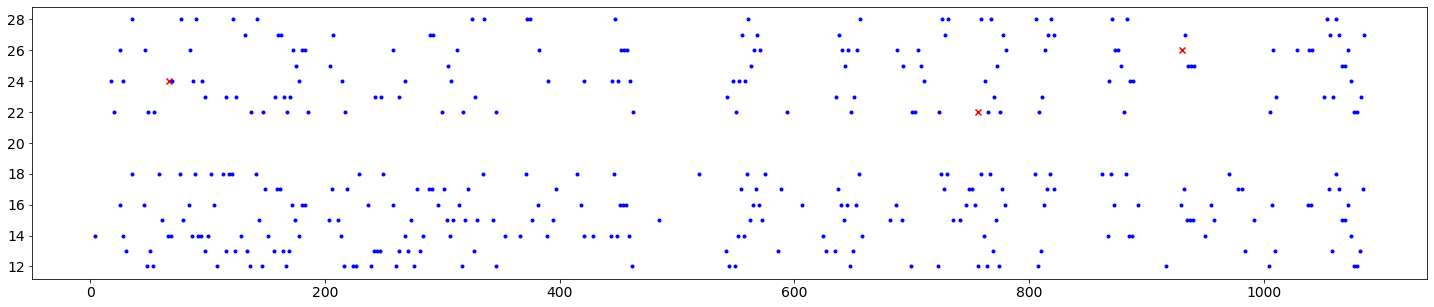

In [ ]:
plot_labels(edf, invalid_sectors)

## Preview sectors

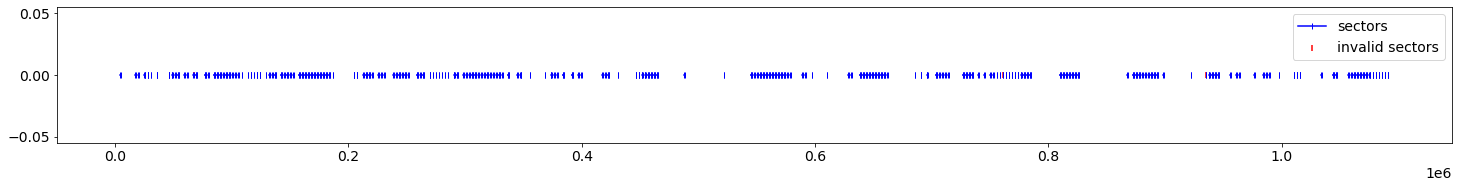

In [ ]:
plot_sectors(sectors, invalid_sectors)

## Preprocess

In [ ]:
channels_data = subselect_channels(edf)
_, lengths, durations, splitted = split_sectors(edf, channels_data, sectors)
t, freq, morlet = morlet_wavelet_pass(splitted)
morlet = transpose_morlet_channel_data(morlet)
morlet = abs_morlet_data(morlet)

Available channels: ['EEG O1-M1', 'EEG O2-M2', 'EEG P3-M1', 'EEG P4-M2', 'EEG C3-M1', 'EEG C4-M2', 'EEG F3-M1', 'EEG F4-M2', 'EEG Fp1-M1', 'EEG Fp2-M2', 'EEG T5-M1', 'EEG T6-M2', 'EEG T3-M1', 'EEG T4-M2', 'EEG F7-M1', 'EEG F8-M2', 'EEG Fz-M1', 'EEG Cz-M2', 'EEG Pz-M1', 'METKA']


## Preview channel samples

(600,) (30,) (30, 600)
(600,) (30,) (30, 600)
(600,) (30,) (30, 600)
(600,) (30,) (30, 600)


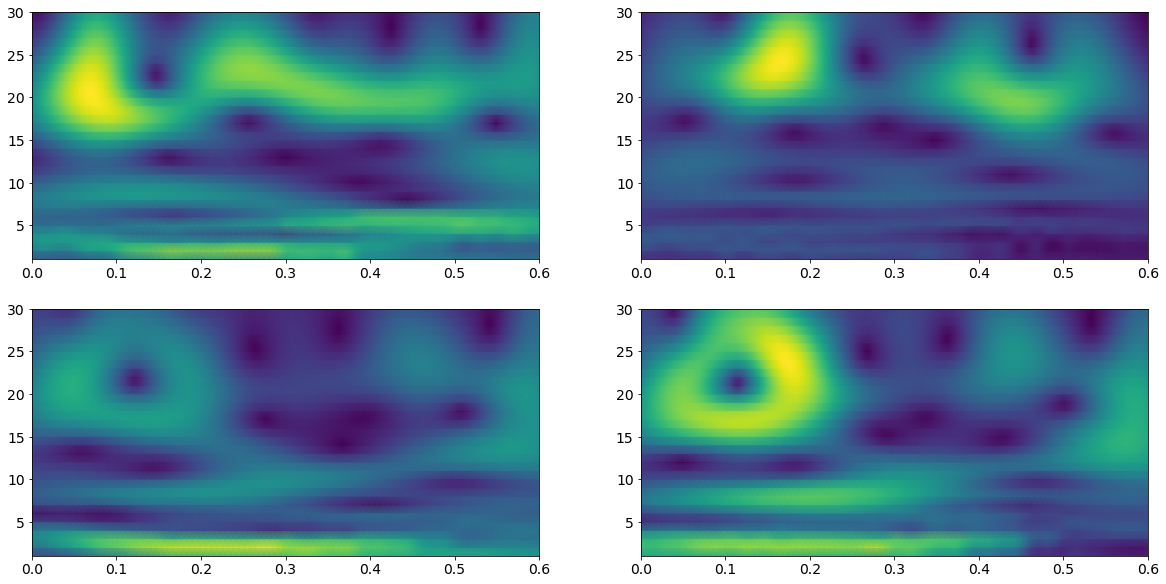

In [ ]:
index = 0

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.size"] = 14
fig, axs = plt.subplots(2, 2)

for channel in range(4):
	value = np.abs(morlet[index][channel])
	print(t.shape, freq.shape, value.shape)
	
	axs[channel % 2][channel // 2].pcolormesh(t, freq, value, cmap='viridis', shading='gouraud')

plt.show()

## Example data statistics

In [ ]:
normalized_labels = normalize_labels(labels)
grouped_morlet_list = group_morlet_by_phoneme(normalized_labels, morlet)

print('phonemes:   ', 'len(grouped_morlet_list)', len(grouped_morlet_list))
print('samples ph0:', 'len(grouped_morlet_list[0])', len(grouped_morlet_list[0]))
print(' total:     ', sum([ len(s) for s in grouped_morlet_list ]))
print('channels:   ', 'len(grouped_morlet_list[0][0])', len(grouped_morlet_list[0][0]))
print('frequencies:', 'len(grouped_morlet_list[0][0][0])', len(grouped_morlet_list[0][0][0]))
print('ticks       ', 'len(grouped_morlet_list[0][0][0][0])', len(grouped_morlet_list[0][0][0][0]))

phonemes:    len(grouped_morlet_list) 7
samples ph0: len(grouped_morlet_list[0]) 53
 total:      358
channels:    len(grouped_morlet_list[0][0]) 4
frequencies: len(grouped_morlet_list[0][0][0]) 30
ticks        len(grouped_morlet_list[0][0][0][0]) 600


## Example save & load

In [ ]:
save_person_grouped_morlet_list(MORLET_SAVE_DIR, 0, grouped_morlet_list)

In [ ]:
loaded_data = load_person_grouped_morlet_list(MORLET_SAVE_DIR, person=0)

In [ ]:

print('phonemes:   ', 'len(grouped_morlet_list)', len(loaded_data))
print('samples ph0:', 'len(grouped_morlet_list[0])', len(loaded_data[0]))
print(' total:     ', sum([ len(s) for s in loaded_data ]))
print('channels:   ', 'len(grouped_morlet_list[0][0])', len(loaded_data[0][0]))
print('frequencies:', 'len(grouped_morlet_list[0][0][0])', len(loaded_data[0][0][0]))
print('ticks       ', 'len(grouped_morlet_list[0][0][0][0])', len(loaded_data[0][0][0][0]))

labels, ungrouped_loaded_data = ungroup_morlet_by_phoneme(loaded_data)
ungrouped_loaded_data = np.asarray(ungrouped_loaded_data)
ungrouped_loaded_data.shape

phonemes:    len(grouped_morlet_list) 7
samples ph0: len(grouped_morlet_list[0]) 53
 total:      358
channels:    len(grouped_morlet_list[0][0]) 4
frequencies: len(grouped_morlet_list[0][0][0]) 30
ticks        len(grouped_morlet_list[0][0][0][0]) 600


(358, 4, 30, 600)